In [561]:
"""
import modules
"""

from prepare_data import prepare_df_from_mac_5_year as prepare_CCL
from prepare_data import prepare_paths as prepare_paths
from emulate_reduction import emulator_v4 as emulate
from visualize_output import vis_emulator_v1 as v1_plot
from pym import pym

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os

dir(prepare_paths)

['Color',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '__warningregistry__',
 'colors',
 'combine_azure_ctax',
 'np',
 'os',
 'output_costs_timer',
 'pd',
 'plot_MAC',
 'plt',
 'prepare_data',
 'pym',
 'truncate_colormap',
 'world_MAC_data']

In [562]:
"""
load data (cubic cubicroot linear and IAMC)
"""

PATH = 'C:/Users/toonv/Documents/PBL/Data/cost curves/'
PATH_IAMC = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths/'
PATH_IAMC_MYM = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_mym/'
PATH_IAMC_CSV = 'C:/Users/toonv/Documents/PBL/Data/IAMC_paths_csv/'

FILENAME_LIN = 'costcurve_co2_linear.dat'
FILENAME_CUBIC = 'costcurve_co2_cubic.dat'
FILENAME_CUBICROOT = 'costcurve_co2_cubicroot.dat'
FILENAME_IAMC = 'iamc15_scenario_data_world_r2.0.xlsx'
FILENAME_MEAN_TEMP = 'mean_temp.csv'

df_linear = pd.read_table(PATH + FILENAME_LIN,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubic = pd.read_table(PATH + FILENAME_CUBIC,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_cubicroot = pd.read_table(PATH + FILENAME_CUBICROOT,
                          skiprows = [0,1,2], sep = ',', names = list(range(1,27)), index_col=False)

df_combined = pd.concat([df_linear, df_cubic, df_cubicroot])
df_cubic_cubicroot = pd.concat([df_cubic, df_cubicroot]) 

# new paths, from IAMC databese
IAMC_database = pd.read_excel(PATH_IAMC + FILENAME_IAMC, sheet_name='data')

In [568]:
"""
global variables 

year, region functie aanroepen waar je jaar en regio in kan vullen die alle stappen dan uitvoert.\\

dit zijn global constants dus kan gewoon in kleine letters

"""

year = 2060
region = 11
TIMERSTEP = 10
test_size = 0.2
stepsize_ctax_paths = 10
number_of_weights = 2

In [573]:
"""
load reductions calculated using the costcurvecooker

input: csv of all reductions (prepared using organize_azure_output.py)
        and definded ctax paths 
        
output: pandas dataframe with ctax paths and reductions until given year
"""

reload(prepare_paths)

# load reduction from azure output
emissions = pd.read_csv('C:/Users/toonv/Documents/PBL/Data/co2tax_total.csv')
years = [1971, 1981, 1991, 2001, 2011, 2021, 2031, 2041, 2051, 2061, 2071, 2081, 2091, 2100]
columns = ['region', 'ctax_index'] + years  # dont know how to set headers for multi-index
emissions.columns = columns

baseline = emissions.loc[emissions.ctax_index == 0]

# load ctax paths csv
ctax_paths = pd.read_excel('C:/Users/toonv/Documents/PBL/Data/IAMC_paths/all_ctax_paths.xlsx', index_col=[0])
ctax_paths.index.name = 'ctax_index'

# functie met jaar en regio geeft dataframe met paths en reducties (%)
data_for_emulator = prepare_paths.combine_azure_ctax(year, region, ctax_paths, reductions, baseline)

# prepare_paths.plot_MAC(data_for_emulator)



In [574]:
"""
prepare data using prepare_df

input: MAC sets (df)

output: ctax paths with reduction
"""
reload(prepare_CCL)

lin_reduction = prepare_CCL.reduction_df(df_linear, year, region)
cubic_reduction = prepare_CCL.reduction_df(df_cubic, year, region)
root_reduction = prepare_CCL.reduction_df(df_cubicroot, year, region)

lin_paths = prepare_CCL.find_path(lin_reduction, 'linear', TIMERSTEP)
cubic_paths = prepare_CCL.find_path(cubic_reduction, 'cubic', TIMERSTEP)
root_paths = prepare_CCL.find_path(root_reduction, 'cubicroot', TIMERSTEP)

combi = pd.concat([cubic_paths, root_paths])
combi.year = cubic_paths.year
combi.region = cubic_paths.region

print(combi.year)

combi.tail()

2060


,2020,2030,2040,2050,2060,reduction
196,0.0,2469.445258,3111.306062,3561.556362,3920.0,95.4218
197,0.0,2482.044468,3127.180072,3579.727568,3940.0,95.4228
198,0.0,2494.643679,3143.054083,3597.898774,3960.0,95.4238
199,0.0,2507.242889,3158.928093,3616.069980,3980.0,95.4248
200,0.0,2519.842100,3174.802104,3634.241186,4000.0,95.4258


[[   0.    0.    0.    0.    0.]
 [   0.    5.   10.   15.   20.]
 [   0.   10.   20.   30.   40.]
 ...
 [   0.  990. 1980. 2970. 3960.]
 [   0.  995. 1990. 2985. 3980.]
 [   0. 1000. 2000. 3000. 4000.]]


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:82: RuntimeWarning: invalid value encountered in true_divide
  delta_c_norm = delta_cs / final_ctax[:, None]
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduction_step[self.year] = train_reduction_step[self.year].round(0)
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


weights dataframe: 
             0          1  ctax
0    0.000000   0.000000     0
1  -14.283412  -7.691068   200
2  -23.897228 -12.867738   400
3  -36.936983 -19.889145   600
4  -42.088514 -22.663046   800
5  -33.059660 -17.801355  1000
6  -16.849399  -9.072754  1200
7  -10.657742  -5.738784  1400
8   -3.008685  -1.620061  1600
9    8.569854   4.614537  1800
10  10.539684   5.675215  2000
11   8.891459   4.787709  2200
12   8.305497   4.472191  2400
13   6.089375   3.278894  2600
14   1.587415   0.854762  2800
15  -0.663565  -0.357304  3000
16  -2.569277  -1.383457  3200
17  -2.767990  -1.490456  3400
18  -0.278606  -0.150018  3600
19  -0.278606  -0.150018  3800
20  -0.278606  -0.150018  4000


C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:103: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_reduction_step[self.year] = train_reduction_step[self.year].round(0)
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lin_reduction_step[self.year] = lin_reduction_step[self.year].round(0)
C:\Users\toonv\Documents\PBL\Code\Emulator\emulate_reduction\emulator_v4.py:103: SettingWithCopyWarning: 
A valu

,test reduction,final ctax,real reduction
0,17.340200,60.0,17.3402
1,32.681093,180.0,27.0673
2,40.779593,260.0,35.1658
3,54.235000,340.0,44.8427
4,60.671200,400.0,51.2789
5,66.105800,460.0,56.7135
6,74.296300,520.0,59.7790
7,74.999800,540.0,60.4825
8,76.766200,600.0,62.2489
9,77.419800,620.0,62.9025


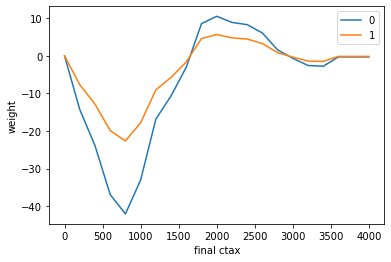

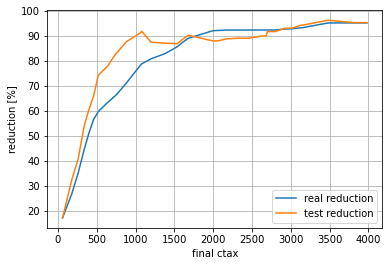

In [572]:
"""
train prepared dataframe 

input: ctax paths with reduction

output: trained dataset
"""

reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, cubic_paths, test_size)

# x = emulate.CtaxRedEmulator(data_for_emulator[0:101], data_for_emulator, test_size)

x.train_ctax_path(stepsize_ctax_paths, number_of_weights)   
    
x.test_ctax_paths() 


method:  multivariate linear regression 
 RMSE:  31.23084504087102 
 R-squared:  0.5306580116107417
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


best params:  {'C': 10, 'gamma': 1e-05, 'kernel': 'rbf'}
method:  SVM 
 RMSE:  3.933105949105422 
 R-squared:  0.992556225145381


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.2s finished


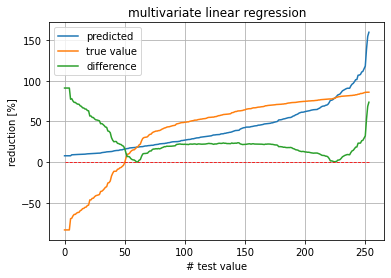

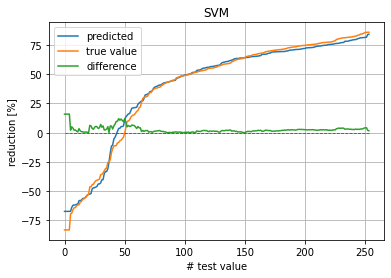

In [571]:
reload(emulate)

x = emulate.CtaxRedEmulator(lin_paths, data_for_emulator, test_size)

# multi linear regression model
multi_lin_regr_mod = x.train_ctax_MLR()
multi_lin_plot = x.test_regr(multi_lin_regr_mod)

# polynomial regression model
# degree = 3
# poly_regr_mod = x.train_ctax_PR(degree)
# poly_regr_plot = x.test_regr(poly_regr_mod)

# # Ridge regression
# alpha = 1
# ridge_mod = x.train_ctax_ridge(alpha)
# ridge_plot = x.test_regr(ridge_mod)

# # lasso regression
# alpha = 1
# lasso_mod = x.train_ctax_lasso(alpha)
# lasso_plot = x.test_regr(lasso_mod)

# Regression tree
# max_depth = 5
# regr_tree = x.train_ctax_tree(max_depth)
# tree_plot = x.test_regr(regr_tree)

# Random forest
# regr_forest = x.train_ctax_forest(max_depth)
# forest_plot = x.test_regr(regr_forest)

# SVM
svm_regr = x.train_SVM()
svm_plot = x.test_regr(svm_regr)

# # MLPRegressor
# MLP_regr = x.train_MLPRegressor()
# MLP_plot = x.test_regr(MLP_regr)

# TensorFlow
# TF_regr = x.train_TF()
